# Stellar photometry

In this tutorial we will describe how images of stars collected on a relatively clear night can be used to measure their effective temperatures, using a technique called _aperture photometry_. At its core, this method relies on accurately counting the number of photons that a target star emits relative to some reference star. The number of photons detected by each star can be indirectly measured by counting the number of photoelectrons (the "counts") that the camera's sensor emits when a photon strikes it. Once we have this data, we can use known properties of the reference star to then infer the desired properties of the target star.

In what follows, we will use images containing two stars: HR7730 (which we will take as our "target" star whose temperature is to be measured) and HR7735 (which we will take as our "reference" star whose magnitudes are known).


In [1]:
# The following lines are required so that the local ``astrolab`` package can be recognised by Python. 
# This is only necessary if you haven't installed the ``astrolab`` package on your machine.

import os
import sys
sys.path.insert(0, os.path.abspath("../../.."))

In [2]:
# Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from astrolab import imaging as im
from astrolab import photometry as phot

## Loading an image for photometry

If you have gone through the [Basic Image Reduction](image-reduction-tutorial.ipynb) tutorial notebook, you should know that to properly analyse any image, it first needs to be "reduced" using calibration frames (darks, biases, and flats). In this tutorial, as in previous tutorials, we will ignore this calibration, and leave it as an exercise. 

We will focus our attention instead on loading this image and getting an estimate of the relative number of photons observed from one star (our "target") relative to a "reference" star. Keep in mind, however that every light frame should ideally first be reduced, and only then should the procedure detailed here be applied.

Let us start by first loading an image (in the red filter) containing both the target and reference stars that we will use for our photometry exercise. While there is no strict requirement that both stars be captured in the same image frame, it is better if they are, since we will be assuming throughout the rest of this process that the light from both stars undergoes the same atmospheric distortions so that they can be safely compared to each other.

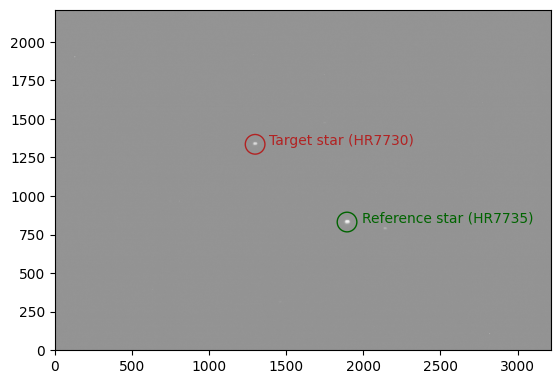

In [3]:
data = im.load_image("./data/photometry/HR7730-R.fit") # Load an image

fig, ax = plt.subplots()                    # Create a blank canvas
im.display(data, fig=fig, ax=ax, log_a=1e4) # Display the image (stretching it appropriately to see features clearly)

# Display some annotations on the graph, to identify the stars
ax.scatter(1298, 1335, s=200, facecolor='none', edgecolor='firebrick') # Draw a large red circle around the target
ax.text(1390, 1335, "Target star (HR7730)", color='firebrick')         # Add text near the red circle
ax.scatter(1894, 831,  s=200, facecolor='none', edgecolor='darkgreen') # Draw a large green circle around the reference
ax.text(1994, 831, "Reference star (HR7735)", color='darkgreen')       # Add text near the green circle
plt.show()

## Getting the relative magnitude of a star in one filter

### Getting counts from the target star

We will now explain how the ``photometry`` module can be used to compare the number of photons received from both stars. We will start by measuring the number of counts -- that is, the number of photo-electrons detected by the camera's sensor -- due solely to the target star.

#### Cropping the image

For simplicity, and to speed up our code, we will only consider a small "postage stamp" of the full image, centred around the star. In the cell below, we will first find the exact location of the target star using a rough estimate of its location, and then crop it to produce the ``cropped_targ``.

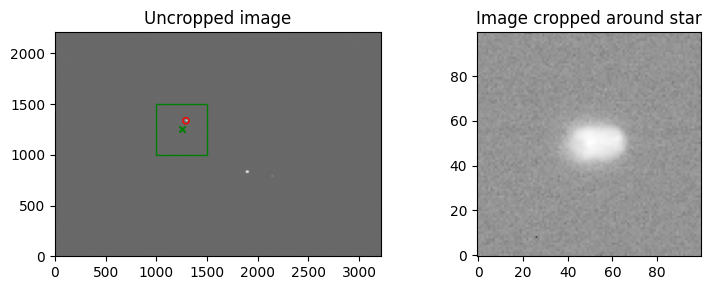

In [4]:
# First crop the image around the target star so that we have a "postage-stamp"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))     # Create a blank canvas with two plots
axes[0].set_title("Uncropped image")                          # Set the title of the two plots
axes[1].set_title("Image cropped around star")

# Find the star using a "rough" location. Plot the guess on the left plot
target = im.find_star(data, star_pos = [1250, 1250], print_log=True, fig=fig, ax=axes[0])

# Crop a region of (100 x 100) pixels around the star (50 above, 50 below, etc) and plot it on the right plot
cropped_targ = im.crop(data, origin=target, left=50, right=50, top=50, bottom=50, print_log=True, fig=fig, ax=axes[1])
plt.tight_layout()

#### Performing aperture photometry

We will now go on to do the main part of this experiment: aperture photometry. The idea behind this technique is to draw circles (or "apertures") around the star and count the values in each pixel (the "counts") within each aperture. We will then plot the values in each aperture as a function of the aperture radius.

What we would naively expect is that as the circle becomes much larger than the star, the number of counts from the star will "plateau" out, reaching a constant value. This constant value would then be the total number of "counts", which is indirectly a measure of the total number of photons, received from the star. However, as we shall see below, this is not the whole story, and some additional work will have to be done.

We will begin by naively performing aperture photometry using the ``get_star_counts`` function in the ``photometry`` module. Make sure to use the ``print_log`` feature of this function, as it will give you a better understanding of what the function is doing.

Star counts: 290624.0 (averaging over 1 points).


290624.0

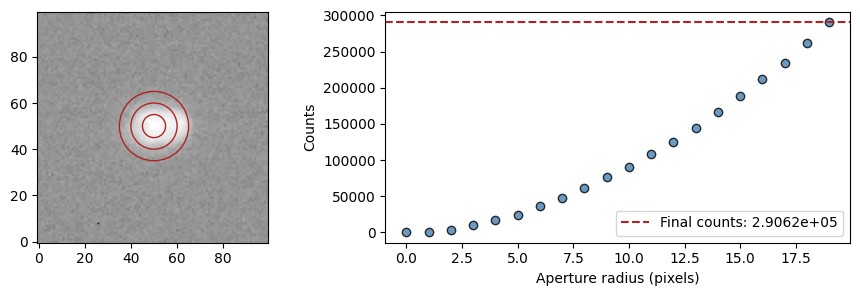

In [5]:
# Get the counts from the star

phot.get_star_counts(cropped_targ, print_log=True)

As you can see, the log of the function produces two images: on the left you see the postage stamp of the star, with some of the apertures plotted on it (the number of the plotted apertures can be controlled using the optional ``plot_apertures`` parameter of this function); on the right, you see the total counts in each aperture as a function of the aperture radius. Clearly, there are many more apertures than the ones shown on the left; many have been skipped to avoid crowding the plot.

However, even though the largest aperture is "beyond" the star, the counts don't seem to be plateauing out to a constant value. Below, we will increase the number of radii, and show that even when we get very far from the star, this number does not reach a "constant" value.

Star counts: 1154869.0 (averaging over 1 points).


1154869.0

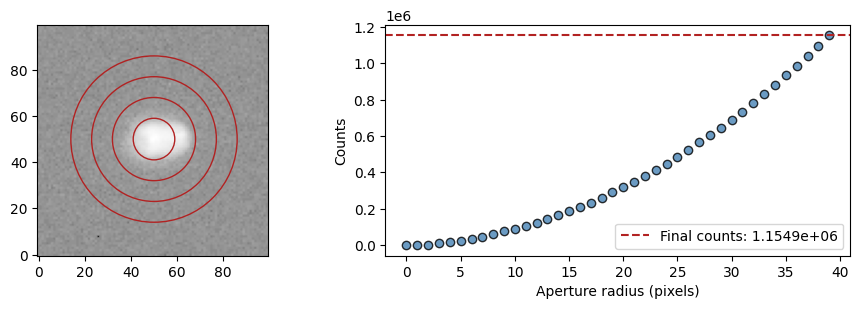

In [6]:
# Going further away from the star

phot.get_star_counts(cropped_targ, print_log=True, radii=np.arange(40))

The reason for this "strange" behaviour is that our naive expectation of the counts plateauing is not strictly correct. It is true that if there were just a star and no background in this image, one would see the value plateau. However, this image does have some overall background behind the star, and this background contributes a more or less constant value per pixel, so as you go further away from the star, this background just keeps adding up. A little reflection will convince you that even though the background's effect is most noticeable far away from the star, it is also present "behind" the star! Thus, to accurately get the number of counts from the star, we need to remove the contribution of the background from every pixel.

In order to do this, the ``get_star_counts`` function also has an optional ``bkg_counts_pp`` argument which can be used to subtract the background counts per pixel from every pixel. Below we show three different "guesses" for the background counts per pixel. Notice how in each case how the ``bkg_counts_pp`` affects the final graph of counts as a function of aperture.

- In the first case, the background counts are too low, which is why the star counts continue to increase beyond the star.
- In the second case, the background counts are too high, meaning that the star's counts actually start to _decrease_. This cannot be an actual effect, and must be due to the fact that the background counts per pixel is too high.
- In the third case, the value of the counts seems to more or less become constant towards the end, meaning that the value used here is closest to the "actual" value of the background counts per pixel.

Star counts: 31874.0 (averaging over 1 points).
Star counts: 9374.0 (averaging over 1 points).
Star counts: 20624.0 (averaging over 1 points).


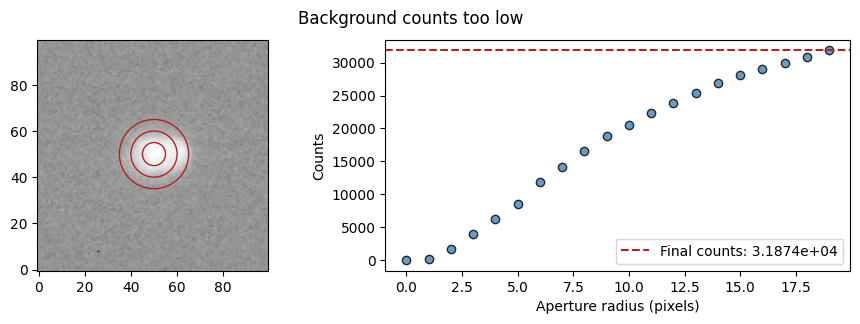

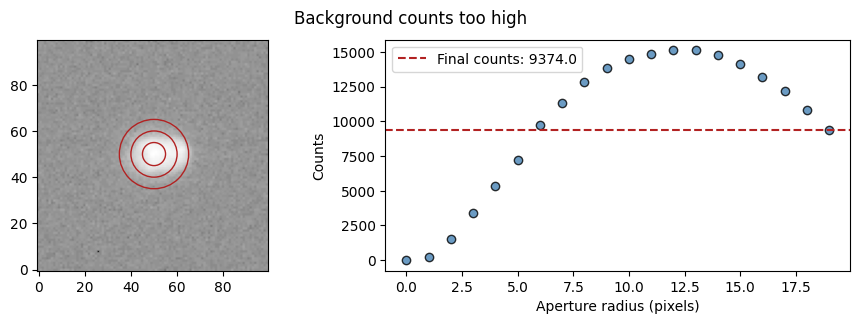

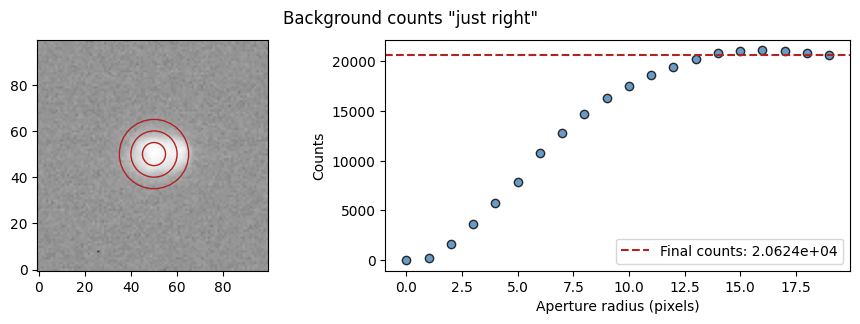

In [7]:
# Performing aperture photometry on the same star with three different values of background counts per pixel.
# In each case, a title is added after the plot has been created, for clarity.

phot.get_star_counts(cropped_targ, bkg_counts_pp=230, print_log=True) 
plt.gcf().suptitle("Background counts too low");                      # Add a title for the first plot

phot.get_star_counts(cropped_targ, bkg_counts_pp=250, print_log=True) 
plt.gcf().suptitle("Background counts too high");                     # Add a title for the second plot

phot.get_star_counts(cropped_targ, bkg_counts_pp=240, print_log=True)
plt.gcf().suptitle("Background counts \"just right\"");               # Add a title for the third plot

#### Identifying the background automagically

As the previous cell shows, however, the value of the star's final counts is very sensitive to the value of the background counts per pixel. Consequently, it is important for us to be able to measure this value accurately, and not have to do it by trial and error.

This can be done using the ``get_bkg_counts_pp`` function of the ``photometry`` module. This function is very involved, and it is strongly recommended that you go through its documentation to understand all the different things it can do. For now, however, we will only use its most basic features.

At its most basic, this function does the following:
1. It first selects ``n_apertures``, of radius ``aperture_rad``, randomly distributed over the image, as shown on the figure on the left.
2. It then computes the background counts per pixel for each of these apertures.
3. Next, many of these apertures are rejected, if their "counts per pixel" are too far away from the mean counts per pixel. In other words, this function automatically rejects any apertures whose counts per pixel are more than ``n_sigma`` away from the mean.
4. The resulting apertures are shown on the figure on the right. The average value of the counts per pixel for all these apertures is returned.

**Note:** The above method assumes that the star is not in "crowded" field. In other words, it assumes that if many random apertures are placed on an image, the majority of these apertures will lie on the background, and a minority will lie on stars. This is true for most of the images that you will take for this experiment. However, if this is not the case, the apertures may also be manually placed on the image. For more information, look at the documentation of this function.

In the next cell, you will see that the computed value of background counts per pixel is very close to our "guess" in the previous cell. We will store this value in a variable, and get the counts from the target star in the following cell.

Background counts per pixel:  237.3952


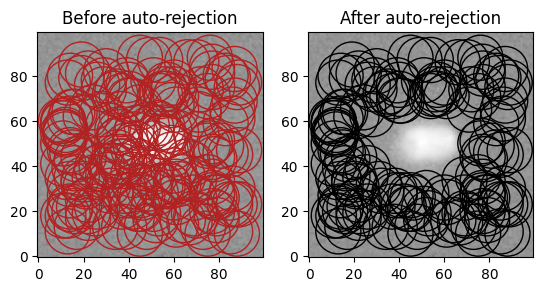

In [8]:
# Getting the background counts per pixel for the target star

targ_bkg_counts_pp = phot.get_bkg_counts_pp(cropped_targ, n_sigma=3, print_log=True)

We can now use this stored value on the ``get_star_counts`` function. As can be seen, the star counts clearly plateau after a certain radius. This "constant" value is, as we argued earlier, the total number of counts received from the star. Of course, the value will never quite be constant, but will show some variation, as is only to be expected since the background will always have some noise. One way to account for this is to average some number of points on the plateau, which can be done using the ``points_to_avg`` parameter of the ``get_star_counts`` function, which will average the last "n" points and return the star's counts.

Star counts: 23729.55859375 (averaging over 10 points).


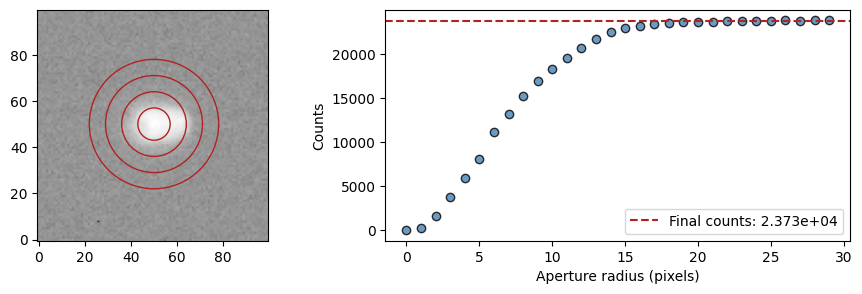

In [9]:
# Getting the star counts for the target star

targ_counts = phot.get_star_counts(cropped_targ, bkg_counts_pp=targ_bkg_counts_pp, radii=np.arange(30), points_to_avg=10, print_log=True)

### Getting counts of the reference star

In the last six cells, we have very carefully measured the counts from the target star. Now that we know how this method works, we can very easily apply the same technique to the reference star, in a single cell below. As before, the three steps are:

1. Roughly locate the star and crop it to create a "postage stamp".
2. Find the average background counts per pixel.
3. Use this background counts per pixel to perform aperture photometry and get the star's counts.

Background counts per pixel:  237.6421
Star counts: 103541.953125 (averaging over 10 points).


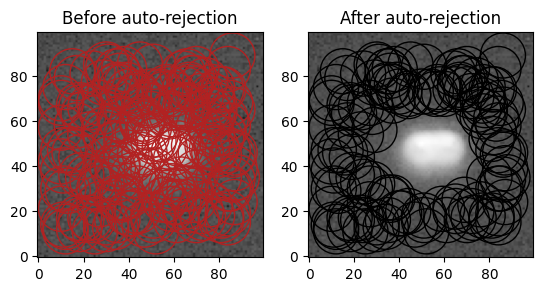

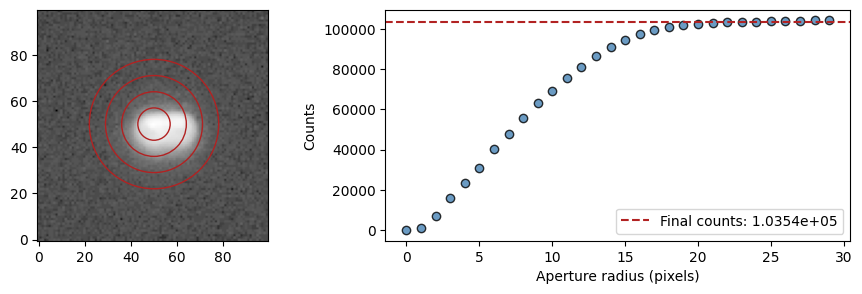

In [10]:
# Create a postage-stamp of the reference
ref = im.find_star(data, star_pos = [1800, 800])
cropped_ref = im.crop(data, origin=ref, left=50, right=50, top=50, bottom=50)

# Compute the background counts
ref_bkg_counts_pp = phot.get_bkg_counts_pp(cropped_ref, n_sigma=3, print_log=True)

# Compute the reference counts
ref_counts = phot.get_star_counts(cropped_ref, radii=np.arange(30), bkg_counts_pp=targ_bkg_counts_pp, points_to_avg=10, print_log=True)

### Get magnitude of target star relative to the reference star

Once we have these counts, we can find the relative magnitude of the target star. The magnitude of a star is defined as 

$$m_\text{targ} = -2.5 \log_{10} \left( \frac{n^\text{photons}_\text{targ}}{n^\text{photons}_\text{ref}}\right) = -2.5 \log_{10} \left( \frac{C_\text{targ}}{C_\text{ref}}\right),$$

where in the last step we have used the fact that the number of photons is proportional to the "counts" of a star produced by the camera's sensor. In the "Vega system", the reference star is taken to be Vega. Thus, in this system, all magnitudes are measured relative to Vega, which is considered to be a "magnitude 0" star. If, however, we use our "reference" star as the reference, then we will get the magnitude of the target star relative to the reference star. 

In the following cell, we will apply this simple formula to get the magnitude of the target star relative to the reference star. It should be clear that this is the magnitude in the _red_ band, since we have used the red-filter image for our analysis. (Note that a star might be "brighter" than another in one filter, and their roles might be reversed in another filter. )

In [11]:
targ_rel_R_mag = -2.5*np.log10(targ_counts/ref_counts)
print("Magnitude of HR7730 in R filter, relative to HR7735:", targ_rel_R_mag)

Magnitude of HR7730 in R filter, relative to HR7735: 1.599566787481308


## Repeating for multiple filters

We now need to repeat the entire process above for multiple filters. The easiest way by far to do this is to write a simple function which, given a filter name ("R", "G", or "B") will get the counts for the target and reference stars. This process is easily automated since the only input that the user needs to give is the filter name, and the rough guess of each star. We define such a function in the cell below, and apply it to get the counts in the red, green, and blue images in the following cell.

In [12]:
def run_multiple(filter, guess_targ = [1250, 1250], guess_ref = [1800, 800]):
    data = im.load_image(f"./data/photometry/HR7730-{filter}.fit") # The filenames' suffix is conveniently the filter-name
    
    ref = im.find_star(data, star_pos = guess_ref)  # Get the exact location of the reference star
    cropped_ref = im.crop(data, origin=ref, left=100, right=100, top=100, bottom=100) # and crop it

    target = im.find_star(data, star_pos = guess_targ) # Get the exact location of the target star
    cropped_targ = im.crop(data, origin=target, left=100, right=100, top=100, bottom=100) # and crop it

    # Compute the background counts
    ref_bkg_counts_pp = phot.get_bkg_counts_pp(cropped_ref, n_sigma=3)   # Note that different background counts are needed
    targ_bkg_counts_pp = phot.get_bkg_counts_pp(cropped_targ, n_sigma=3) # because the background around each star may differ
    
    # Compute the reference counts
    ref_counts  = phot.get_star_counts(cropped_ref,  radii=np.arange(30), bkg_counts_pp=ref_bkg_counts_pp,  points_to_avg=10)
    targ_counts = phot.get_star_counts(cropped_targ, radii=np.arange(30), bkg_counts_pp=targ_bkg_counts_pp, points_to_avg=10)

    return ref_counts, targ_counts

In [13]:
# Run the above function for each filter, getting the target and reference counts in each filter

red_ref, red_targ = run_multiple("R")
green_ref, green_targ = run_multiple("G")
blue_ref, blue_targ = run_multiple("B")

## Getting the absolute magnitude of a star

If we know nothing else, then this is as far as we can go. However, if we are in addition given the absolute magnitude of the reference star relative to (say) Vega, then we can find the magnitude of our target relative to Vega using the simple equation:

$$m^V_\text{targ} = -2.5 \log_{10} \left( \frac{C_\text{targ}}{C_\text{ref}}\right) + m^V_\text{ref}.$$

In this experiment, you will be provided with a bright-star catalog (which can be accessed using the ``get_bright_star_catalog`` function of the ``photometry`` module) which has, among other things, the magnitudes of 1346 bright stars in the filters used by our SBIG STC-7 camera.

The ``photometry`` module also has an additional ``get_mags`` function which applies the above formula to each of the filters, and returns the target star's _absolute_ magnitudes. However, in order to do this, it needs to know the reference star's HR number, which can be passed using the ``reference_hr`` parameter. 

In [14]:
# Create arrays of the red, green, and blue absolute magnitudes (in that order)

all_filters_target    = np.array([red_targ, green_targ, blue_targ])
all_filters_reference = np.array([red_ref, green_ref, blue_ref])

# Apply the ``get_mags`` function to get the absolute magnitudes of the target. The reference star's HR number
# is needed to search the bright-star catalog and obtain its absolute magnitudes.
target_absolute_mags = phot.get_mags(all_filters_target, all_filters_reference, reference_hr=7735)

print("The absolute magnitudes of the target star in R, G, and B filters are ", target_absolute_mags)

The absolute magnitudes of the target star in R, G, and B filters are  [4.89790438 4.83324094 4.85203222]


## Getting the star's effective temperature using a colour-temperature diagram

We can now go one step further, now that we have the absolute magnitudes of the star in the different filters. Using these magnitudes, we can define three "colours", $B-R$, $G-R$, and $B-G$. These colours are the differences of the magnitudes in each band, and therefore represent the ratios of the number of photons obtained in each band (this is because the magnitude scale is logarithmic, and subtraction of two logarithms is the logarithm of the ratio of their arguments).

It turns out that each of these "colours" is strongly correlated to the effective _temperature_ of the star. While we do not know the exact relationship, we can derive an _empirical_ relationship from the 1346 bright-star catalog provided. You will not have to derive this relationship in the experiment (although it can be done quite easily); you will instead use this relationship to obtain the star's effective temperature. 

In order to obtain its temperature, we need to
1. Compute the colours of the star (given the magnitudes).
2. Find which temperatures correspond to each colour.
3. Return the closest temperature for each colour.

All of this can be done using the ``get_temp`` function of the ``photometry`` module. In the cell below, we use the absolute magnitudes of the target star and send them into the ``get_temp`` function. The log of this function is also very useful, as it plots the curves representing the different empirical relationships for each colour, as well as the effective temperatures obtained. The different temperatures obtained from each colour can be used to define an "uncertainty" in the final value of the temperature.

The different colours give us the following temperatures (in K) for the target star [7911.6115 7779.6715 8054.5116]
The mean temperature of the target is 7914 +/- 112 K


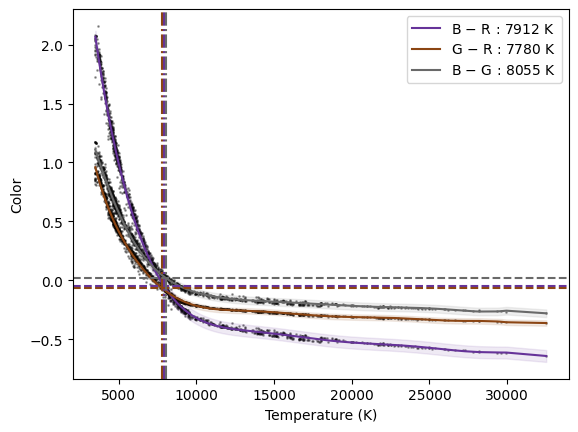

In [15]:
temps = phot.get_temp(target_absolute_mags, print_log=True)
print("The different colours give us the following temperatures (in K) for the target star", temps)

target_temp = np.mean(temps, dtype=int)     # Find the average temperature
target_temps_std = np.std(temps, dtype=int)  # Find the deviation in the temperature values, to be used as an "uncertainty"
print("The mean temperature of the target is", target_temp, "+/-", target_temps_std, "K")

In the above cell, both from the graph as well as the values, you can see that all three of the colours give us very similar temperatures for the star. Note that in principle, we only need _one_ colour and _one_ empirical curve to arrive at a temperature. However, since we have three colours, we can use all three of them to get an answer of which we are more certain!

Furthermore, since we have chosen a target star that _also_ happens to be in our bright-star catalog, we can now query this catalog to see how close (or far!) we are to the "actual" effective temperature of the star. This can be done using the ``get_star_data`` function of the ``photometry`` module. This function accepts a star's HR number as well as a catalog, and returns the attribute of the star that is requested. If no catalog is provided, it uses the default 1346 bright-star catalog. 

In the cell below, we query our bright-star catalog for our target star using its HR number (HR7730), and ask for its temperature. This value can be returned either as a Pandas dataframe, or as a NumPy array. Here, we will return it as a NumPy array using the ``return_numpy=True`` option.

In [16]:
target_actual_temp = phot.get_star_data(hr=7730, requested_colnames="Teff(K)", return_numpy=True)

print("The measured temperature is", target_temp)
print("The actual temperature is", target_actual_temp)
print("The percentage error is", np.round(100*np.abs(target_actual_temp-target_temp)/target_actual_temp,2),"%")

The measured temperature is 7914
The actual temperature is 7998
The percentage error is 1.05 %


## Discussion

Using the method described in this notebook, we have found that the target star's "mean" temperature has been measured to within 1% of the actual value. This error is very much in line with the uncertainty from the standard deviation computed above.

It must be noted, however, that the relation shown in the log of the ``get_temp`` function also has its own uncertainty that we have not included in our computation here. This uncertainty is due to the fact that the colour-temperature relation we have obtained is an empirical one, and even though all the stars in our catalog follow it with remarkable accuracy, there is some deviation from this relation. The deviation about the spread are represented by the "filled in" regions around the fit-lines in the figure. If you would like to use these errors, you should run the ``get_color_temperature_fits`` function in the ``photometry`` module with the ``return_err=True`` option. More information can be found in the documentation of this function. We can expect our measure of uncertainty to increase after incorporating this uncertainty as well. Nevertheless, we find that our answer is remarkably accurate.

Another interesting point to mention is that the images of the star that we started with have a "tracking error" in the telescope (the stars are not "round", but seem to have a trail). However, this does not affect our analysis at all, due to the forgiving nature of aperture photometry. Since we are only counting how many photons the star is emitting, it does not matter how "smudged" out our star is. Indeed, it some cases, it can even be desirable to have our star illuminating as many pixels as possible, to reduce the noise in the image.